# This notebook is run by Simone Webb and taken heavily form the Waddington-OT tutroials online

# Import packages

In [1]:
import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import wot
import scanpy as sc
import math

# Reformat scanpy h5ad FBM neutrophil data for input to waddington-OT

At a bare minimum, you technically only need two files to compute transport maps for your data:

1.) an expression matrix: ExprMatrix.h5ad. The expression matrix is formatted with cells on the rows and genes on the columns. Each cell is annotated with a unique barcode, which is used to identify the cell. 

In [2]:
# Load in some FBM neutrophil data as an h5ad 

neuts = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/figs2c_neut_mono_dr_20210111.h5ad")

In [3]:
neuts.shape

(32448, 33712)

In [4]:
cell_numbers = neuts.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                92
MPP myeloid        92
LMPP               34
CMP               425
GMP              1281
MOP              3838
promyelocyte     2191
myelocyte        3794
neutrophil       4501
promonocyte      7437
CD14 monocyte    8763
dtype: int64

In [5]:
#neuts = neuts[~neuts.obs['cell.labels'].isin(["neutrophil"])].copy()

In [6]:
#cell_numbers = neuts.obs.groupby(["cell.labels"]).apply(len)
#cell_numbers

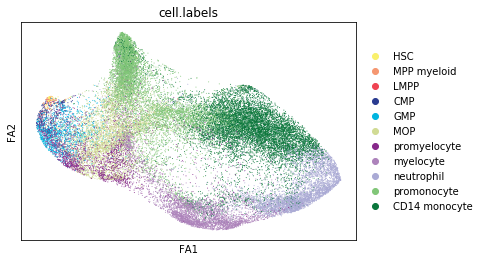

In [7]:
sc.pl.draw_graph(neuts, color=["cell.labels"], layout='fa')

# Save cell days file as csv

2.) a cell days file: cell_days.txt. The cell days file has two columns: one with cell IDs and one with the time of collection

In [8]:
# Save the cell days txt file

fetal_ids = [
 'F38_male_12PCW', 'F45_female_13+6PCW',
 'F30_male_14+3PCW','F50_female_15PCW', 'F51_female_15PCW',
 'F41_female_16PCW', 'F21_male_16+2PCW', 'F29_female_17+0PCW', 
'SB19PCW']

day_ids = ["12", "13", 
            "14", "15", "15", 
             "16", "16", "17", 
            "19"]

neuts.obs["day"] = neuts.obs["fetal.ids"].replace(fetal_ids, day_ids)

cell_numbers = neuts.obs.groupby(["day"]).apply(len)
cell_numbers

day
12      345
13     3393
14     4993
15    15040
16     2807
17     2016
19     3854
dtype: int64

In [9]:
pd.DataFrame(neuts.obs["day"]).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/waddington_neut_mono_cell_days_txt_file_20210209.txt")

In [10]:
adata=neuts

# Save cell sets as .gmt file

Some of our interpretation of transport maps will be based on grouping cells into sets with coherent expression (e.g. iPSCs). 
We recommend that the user define cell sets through a combination of clustering and using gene signature scores. 

In the following code block we load and visualize the cell sets defined in Schiebinger et al 2019. In the following notebooks, we will use optimal transport to examine the developmental trajectories leading to these cell sets.

In [11]:
# need to save the cell type annotation as an input file

my_dict = {}

labs = pd.DataFrame(neuts.obs["cell.labels"])
labs["index"] = labs.index

for i in neuts.obs["cell.labels"].unique():
    barcodes = labs[labs["cell.labels"]==i]["index"].tolist()
    x = str(i) + "_barcodes"
    my_dict[x] = barcodes

my_dict
# convert output dictionary as a df, with col2 empty (sources of geneset/metadata should be stored in geneset .gmt files)
df = pd.DataFrame.from_dict(my_dict, orient='index')
df[0] = "-"
df.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/fbm_neut_mono_cell_sets_20210209.gmt", sep='\t')
df

,0,1,2,3,4,5,6,7,8,9,...,8753,8754,8755,8756,8757,8758,8759,8760,8761,8762
neutrophil_barcodes,-,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ACG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_ATG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CCA...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CGG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CTA...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CTT...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_GAG...,...,None,None,None,None,None,None,None,None,None,None
CD14 monocyte_barcodes,-,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AAG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AGA...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AGT...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CCT...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CGA...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CTC...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CTC...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_GGG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_GTA...,...,TCCATGCTCAGTGATC-1-WSSS_F_BON8710643,TGACAGTAGCCTGAGA-1-WSSS_F_BON8710643,TGCAGTATCACTGTTT-1-WSSS_F_BON8710643,TGGAGAGCACGTGAGA-1-WSSS_F_BON8710643,TGGTAGTGTGTCTCCT-1-WSSS_F_BON8710643,TTACAGGTCACCCTCA-1-WSSS_F_BON8710643,TTACGCCCATGGATCT-1-WSSS_F_BON8710643,TTACTGTAGTTCGCAT-1-WSSS_F_BON8710643,TTGGGATGTGGAACCA-1-WSSS_F_BON8710643,TTGGTTTTCGAGGCAA-1-WSSS_F_BON8710643
promonocyte_barcodes,-,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CAC...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CAT...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CCA...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CGT...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_GAT...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_GGG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_TAG...,F21_boneMarrow_CD45+_FCAImmP7179367_3prime_TAG...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_CAG...,...,None,None,None,None,None,None,None,None,None,None
myelocyte_barcodes,-,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_ACG...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_AGG...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_CGT...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_GAT...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_GCA...,F29_boneMarrow_Total_FCAImmP7292031_5GEX_TACGG...,F30_boneMarrow_CD45-_FCAImmP7277567_3prime_GCA...,F30_boneMarrow_CD45-_FCAImmP7277567_3prime_GTT...,F30_boneMarrow_CD45-_FCAImmP7277567_3prime_TTT...,...,None,None,None,None,None,None,None,None,None,None
MOP_barcodes,-,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_ACT...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_CCA...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_CTT...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_GAT...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_GCG...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_GTG...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_TGC...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_ATA...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_CAC...,...,None,None,None,None,None,None,None,None,None,None
GMP_barcodes,-,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_ACT...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_CTA...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_GAA...,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_GCC...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_ACT...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_ATA...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_ATT...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_CAC...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_CAT...,...,None,None,None,None,None,None,None,None,None,None
promyelocyte_barcodes,-,F21_boneMarrow_CD45-_FCAImmP7179368_3prime_TAG...,F29_boneMarrow_CD45+_FCAImmP7277558_3prime_AGC...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_AGA...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_CTA...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_CTC...,F29_boneMarrow_CD45-_FCAImmP7277559_3prime_GTG...,F30_boneMarrow_CD45+_FCAImmP7277566_3prime_AAC...,F30_boneMarrow_CD45+_FCAImmP7277566_3prime_TAA...,F30_boneMarrow_CD45+_FCAImmP7277566_

In [12]:
# Load cell sets
CELL_SETS_PATH = "/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/fbm_neut_mono_cell_sets_20210209.gmt"
cell_sets = wot.io.read_sets(CELL_SETS_PATH)
cell_sets

AnnData object with n_obs × n_vars = 41199 × 12 
    var: 'description'

In [13]:
cell_sets.var

,description
,0
neutrophil_barcodes,-
CD14 monocyte_barcodes,-
promonocyte_barcodes,-
myelocyte_barcodes,-
MOP_barcodes,-
GMP_barcodes,-
promyelocyte_barcodes,-
CMP_barcodes,-
HSC_barcodes,-


# Compute transport maps

# Step 1: Estimate cell growth rates based on apoptosis/proliferation gene enrichment

Before computing transport maps, we first form an initial estimate of the cell growth rate function $g(x)$. 
We do this using signatures of proliferation and apoptosis computed in Notebook 1. 
Note that we refine this initial estimate using unbalanced optimal transport, as explained later in this notebook. 

We model cellular growth with a Birth-Death Process, which assigns each cell $x$ a *rate* of division $\beta(x)$ and a  rate of death $\delta(x)$. 
In a small interval of time $dt$, these *rates* imply that the probability of a division is $\beta(x)dt$, and the probability of death is $\delta(x) dt$. 
The expected number of descendants after time $dt = t_2 - t_1$ is $e^{dt(\beta(x) - \delta(x))}$.

To compute the birth (i.e. division) rate and death rate, we apply a logistic function to transform the gene set scores into biologically plausible vaules for our reprogramming dataset (where the most proliferative cells double every 9 hours, and the least proliferative cells double every 60 hours). 

# Save growth info as growth_gs_init.txt

In [14]:
# load proliferation and apoptosis scores from W-OT authors github
gene_set_scores = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/gene_set_scores.csv", index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

# apply logistic function to transform to birth rate and death rate
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
gr = np.exp(birth-death)
growth_rates_df = pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr})
growth_rates_df.to_csv('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/growth_gs_init_20210209.txt')

In [15]:
growth_rates_df.max()

cell_growth_rate    4.021473
dtype: float64

In [16]:
growth_rates_df.min()

cell_growth_rate    0.250088
dtype: float64

# Step 2: Compute transport maps (given: GEX, age, cell growth rates computed above)

We are now ready to compute transport maps. 

The next code block reads in the expression matrix, cell days, and the initial cell growth rates we computed in step 1 above. If the cell growth rates are not provided, the algorithm will assume each cell grows at roughly the same rate.  Note that the expression matrix we use here contains variable gene expression data of 1,400 genes from two time-course experiments, and we apply a filter to select cells from the serum time course. 

In [17]:
VAR_GENE_DS_PATH = "/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/figs2c_neut_mono_dr_20210111.h5ad"
CELL_DAYS_PATH = "/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/waddington_neut_mono_cell_days_txt_file_20210209.txt"
CELL_GROWTH_PATH = '/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/growth_gs_init_20210209.txt'

days_df = pd.read_csv(CELL_DAYS_PATH, index_col='index') 
cell_growth_df = pd.read_csv(CELL_GROWTH_PATH, index_col='id') 

# Read scanpy h5ad, plus age and cell growth (based on growth rates computed above)
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[days_df, cell_growth_df])
adata.shape

(32448, 33712)

We solve the following *unbalanced transport* optimization problem introduced in Chizat et al 2018, where we only enforce the row-sum constraints approximately and we add entropy to the transport matrix: 

\begin{equation}
\begin{aligned}
\underset{\pi}{\text{minimize}} & \qquad \iint c(x,y) \pi(x,y) dx dy - \epsilon \int \pi(x,y) \log \pi(x,y) dx dy \\
&\qquad + \lambda_2 {\text{KL}} \left ( \int \pi(x,y) dx  \Big \vert d \hat {\mathbb{P}}_{t_2} (y) \int g(x)^{t_2 - t_1} d \hat {\mathbb{P}}_{t_1}(x) \right ) \\ 
& \qquad + \lambda_1 {\text{KL}} \left ( \int \pi(x,y) dy \Big \vert d \hat {\mathbb{P}}_{t_1} (x) g(x)^{t_2 - t_1} \right). 
\end{aligned}
\end{equation}

Here we use the notation  $\hat {\mathbb{P}}_{t_k} = \frac 1 n \sum_{i=1}^n \delta_{x_i}$ for the empirical distribution of samples $x_1,\ldots,x_n$ at time $t_k$, and $\text{KL}(P \vert Q)$ denotes the KL-divergence between distributions $P$ and $Q$. The function $c(x,y)$ encodes the cost of transporting a unit mass from $x$ to $y$. We define $c(x,y)$ to be the squared euclidean distance between cells in local PCA space. This PCA space is computed separately for each pair of time-points. Finally, the function $g(x)$ encodes the growth rate of cell $x$, and is used to specify the budget of descendant mass for each cell $x_i$ at time $t_1$. 

The optimization problem has three regularization parameters: 
* $\epsilon$ controls the degree of entropy in the transport map. 
A larger value gives more entropic descendant distributions, where cells are able to obtain more fates. 
* $\lambda_1$ controls the constraint on the row sums of $\pi_{t_1,t_2}$, which depend on the growth rate function $g(x)$ 
A smaller value of $\lambda_1$ enforces the constraints less strictly, which is useful when we do not have precise information about $g(x)$.
* $\lambda_2$ controls the constraint on the column sums of $\pi_{t_1,t_2}$.

In the following code block we initialize an OTModel, which is parameterized by $\epsilon, \lambda_1, \lambda_2$.

In [18]:
# create OTModel
ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 
ot_model

We can now use the OTModel to compute transport maps between any pair of time-points. 

In [19]:
# Compute a single transport map from day 12 to 19
tmap_annotated = ot_model.compute_transport_map(12,19)
tmap_annotated

AnnData object with n_obs × n_vars = 345 × 3854 
    obs: 'g0', 'g1'

The object tmap_annotated is an annotated transport matrix, and tmap_annotated.X contains the actual numerical matrix. 
Both rows and columns are annotated with cell barcodes and cell growth rates (just along rows). These annotations are accessed as follows: 

In [20]:
# row annotations include cell growth rates
# G0 = INPUT GROWTH RATE
# G1 = INFERRED GROWTH RATE
tmap_annotated.obs[:5]

,g0,g1
index,,
F38_boneMarrow_CD45+_FCAImmP7528281_3prime_CAGCATAGTATTACCG,3.130973,3.117865
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_AAGGTTCTCACATACG,1.070833,1.093118
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_ACACCAATCATAACCG,0.909753,0.902392
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_ACACTGAGTGCGATAG,0.890859,0.920199
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_ACGGGTCAGAATGTTG,0.676412,0.714513


In [21]:
# columns annotated by cell barcodes
tmap_annotated.var[:5]

""
index
AAACCCACATCCGTGG-1-WSSS_F_BON8710636
AAACGAAAGGTGCCAA-1-WSSS_F_BON8710636
AAACGCTTCCCAGCGA-1-WSSS_F_BON8710636
AAAGAACAGGGTCACA-1-WSSS_F_BON8710636
AAAGAACCACGACTAT-1-WSSS_F_BON8710636


The column `g0` displays the input growth rates and the column `g1` displays the row sums of the transport map (raised to the power $t_2 - t_1$. These values can differ, as we see in the plot below, because the row-sum constraints are only enforced loosely. We interpret the value `g1` as an *inferred growth rate*. 

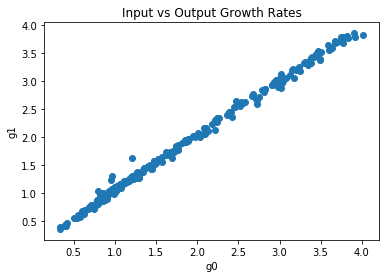

In [22]:
# Visualize how growth rates change with growth iterations
plt.scatter(tmap_annotated.obs['g0'],tmap_annotated.obs['g1'])
plt.xlabel("g0")
plt.ylabel("g1")
plt.title("Input vs Output Growth Rates")
plt.show()

When we increase the regularization parameter $\lambda_1$, the row sum constraints are enforced more strictly. 

Here, we are attepting to push input growth rates caluclated above closer to inferred growth rates

In [23]:
ot_model_strict = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 3,lambda2 = 50) 
tmap_anno_strict = ot_model_strict.compute_transport_map(12,19)

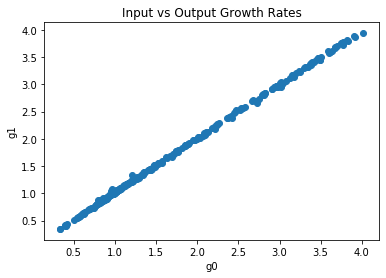

In [24]:
plt.scatter(tmap_anno_strict.obs['g0'],tmap_anno_strict.obs['g1'])
plt.xlabel("g0")
plt.ylabel("g1")
plt.title("Input vs Output Growth Rates")
plt.show()

# Updating growth estimates

We can feed these new growth rates back into the OT solver and recompute transport maps with these new growth rates. Instead of doing this manually, we can specify the number of 'growth iterations' with the flag `growth_iters`.

We interpret these new row-sums as a meaningful estimate of growth rates, and use this to form a new estimate of the growth function g(1) which we can plug back into the OT optimization problem to compute a new transport map π(1). We can therefore iterate back and forth between learning growth rates g(i) and learning transport maps π(i) until the procedure eventually converges. In practice, we find that just a few iterations are usually sufficient.

In [25]:
ot_model_gr2 = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50,growth_iters=2) 
tmap_anno_gr2 = ot_model_gr2.compute_transport_map(12,19)

The row annotations of this transport map now have fields for multiple iterations of learning growth:

In [26]:
# row annotations include initial cell growth rates g0, and also g1 and g2
tmap_anno_gr2.obs[:5]

,g0,g1,g2
index,,,
F38_boneMarrow_CD45+_FCAImmP7528281_3prime_CAGCATAGTATTACCG,3.130973,3.117865,3.097583
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_AAGGTTCTCACATACG,1.070833,1.093118,1.117850
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_ACACCAATCATAACCG,0.909753,0.902392,0.899042
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_ACACTGAGTGCGATAG,0.890859,0.920199,0.950641
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_ACGGGTCAGAATGTTG,0.676412,0.714513,0.754675


# Tuning $\lambda_1$ and $\lambda_2$

The numerical value of $\lambda_1$ determines how different $g_{k+1}$ can be from $g_k$. If growth rates are known very well, then a large value of $\lambda_1$ can be used to enforce the row-sum constraints strictly and we could just do one growth iteration. When we do more than one growth iteration, the value of $\lambda_1$ can be interpreted intuitively as an *inverse step size* in our update of growth rates. A large value allows us to change growth by a lot at each iteration. 

You may have noticed that we set $\lambda_2 = 50$, a much larger numerical value than $\lambda_1 = 1$. This enforces the constraints on the column sums strictly (the amount of mass going into each cell $y$ at time $t_2$ is well specified). To see this, we plot a histogram of column sums, and we see a very narrow band. 

(array([2.00e+00, 0.00e+00, 2.00e+00, 2.00e+00, 2.00e+00, 1.00e+01,
        2.00e+01, 2.00e+01, 7.16e+02, 3.08e+03]),
 array([70.41614, 72.18945, 73.96277, 75.73609, 77.50941, 79.28272,
        81.05604, 82.82935, 84.60268, 86.37599, 88.14931], dtype=float32),
 <a list of 10 Patch objects>)

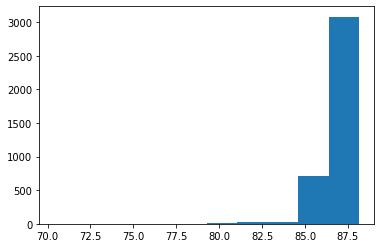

In [27]:
colsums = tmap_anno_gr2.X.sum(axis=0);
plt.hist(colsums)

# Tuning $\epsilon$ 

The parameter $\epsilon$ controls the level of entropy in the transport maps. A larger value promotes more entropic descendant distributions, so each cell can transition to a larger variety of descendants. We recommend sticking with the default value of $\epsilon = 0.05$. Note that we rescale the cost matrix to have a median value of $1,$ so the default value of $\epsilon$ should give similar results for datasets of different scales.  



# Compute all transport maps and save them

The following command computes all transport maps. 

In [28]:
#Note that this can take a few hours on a laptop. For convenience, we include precomputed transport maps in the 
#`tmaps` directory. 
ot_model = wot.ot.OTModel(adata, epsilon = 0.05, lambda1 = 1, lambda2 = 50, growth_iters = 3) 
ot_model.compute_all_transport_maps(tmap_out='tmaps_20210209/')

# Run fate matrices

# Notebook 5: Fate Matrices

In this notebook we show how to compute and visualize 'fates' of cells. 
Consider a pair of time points $t_i < t_j$ and a collection of cell sets $C_1,\ldots,C_k$ spanning all cells at the later time point, $t_j$. (That is, each cell $y$ from time $t_j$ is in some $C_\ell$). 
We show how to compute the probability that a cell $x$ from time $t_i$ will transition to a target destination $C_\ell$ at time $t_j$. 
We call these the *fate probabilities* for cell $x$. The **fate matrix** $F_{t_i,t_j}$ is a matrix with a row containing the fate probabilities for each cell $x$ from time $t_i$.

## Compute fates
We begin by loading into memory
* a `TransportMapModel` from a directory of pre-computed transport maps, and 
* a dictionary of cell sets. 

In [29]:
# Load transport map model and cell sets
tmap_model = wot.tmap.TransportMapModel.from_directory('tmaps_20210209/')
cell_sets = wot.io.read_sets('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/fbm_neut_mono_cell_sets_20210209.gmt', as_dict=True)

Next, we initialize a list of `target_destinations` at time $t_j = 18$. 

In [30]:
# create indicator vectors for each cell set
target_destinations = tmap_model.population_from_cell_sets(cell_sets, at_time=19)

Finally, we compute the fate matrices for each earlier time point $t_i < t_j$ all at once with the  `fates` function. 

In [31]:
fate_ds = tmap_model.fates(target_destinations)

In [32]:
#fate_ds

The resulting dataset `fate_ds` contains the fate matrices for each earlier time point $t_i < t_j$. We can then easily subset this dataset to access the fate matrix $F_{t_i,t_j}$ for any individual day $t_i$.

## Visualizing fate matrices

In the following code blocks we provide two simple tools to visualize fate matrices. First, we plot a fate matrix with $k=3$ fates in barycentric coordinates. This is a handy coordinate system for viewing the three dimensional simplex in two dimensions. A probability vector $(p_1,p_2,p_3)$ is represented inside an equilateral triangle, where each vertex represents a pure fate like $(1,0,0)$ or $(0,1,0)$ or $(0,0,1)$.

In [33]:
fate_dropdown1 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 1:',
)
fate_dropdown2 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 2:',
    value=fate_ds.var.index[1]
)
day_dropdown = widgets.Dropdown(
    options=fate_ds.obs['day'].unique(),
    description='Day',
    value=12
)

def update_fate_vis(name1, name2,day):
    figure = plt.figure(figsize=(10, 10))   

    fate1 = fate_ds[:,name1][fate_ds.obs['day']==day].X.flatten()
    fate2 = fate_ds[:,name2][fate_ds.obs['day']==day].X.flatten()

    Nrows = len(fate1)
    x = np.zeros(Nrows)
    y = np.zeros(Nrows)
    P = np.array([[1,0],[np.cos(2*math.pi/3),math.sin(2*math.pi/3)],[math.cos(4*math.pi/3),math.sin(4*math.pi/3)]])

    for i in range(0,Nrows):
        ff = np.array([fate1[i],fate2[i],1-(fate1[i]+fate2[i])])
        x[i] = (ff @ P)[0]
        y[i] = (ff @ P)[1]

    vx = P[:,0]
    vy = P[:,1]
    t1 = plt.Polygon(P, color=(0,0,0,0.1))
    plt.gca().add_patch(t1)
    
    plt.scatter(x,y)
    plt.scatter(vx,vy)
    #plt.scatter(0,0)
    plt.text(P[0,0]+.1, P[0,1], name1)
    plt.text(P[1,0]-.1, P[1,1]+.1, name2)
    plt.text(P[2,0]-.1, P[2,1]-.2, 'Other')
    plt.axis('equal')
    plt.axis('off')
    #plt.xticks([])
    #plt.yticks([])
    
    plt.title('{} vs. {} on day {}'.format(name1, name2,day))

widgets.interact(update_fate_vis, name1=fate_dropdown1, name2=fate_dropdown2,day=day_dropdown)

interactive(children=(Dropdown(description='Fate 1:', options=('neutrophil_barcodes', 'CD14 monocyte_barcodes'…

<function __main__.update_fate_vis(name1, name2, day)>